# Deep Learning for Computer Vision:  Assignment 2


## Computer Science: COMS W 4995 004


## Due: February 27, 2018

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu or leaky ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing you own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisey as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 85%, e=10%, f=5%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,1.006765,0.048384,1.0
1,0.054233,-0.210380,0.0
2,1.011839,-0.117351,1.0
3,0.157775,1.019227,1.0
4,0.016562,-0.258480,0.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

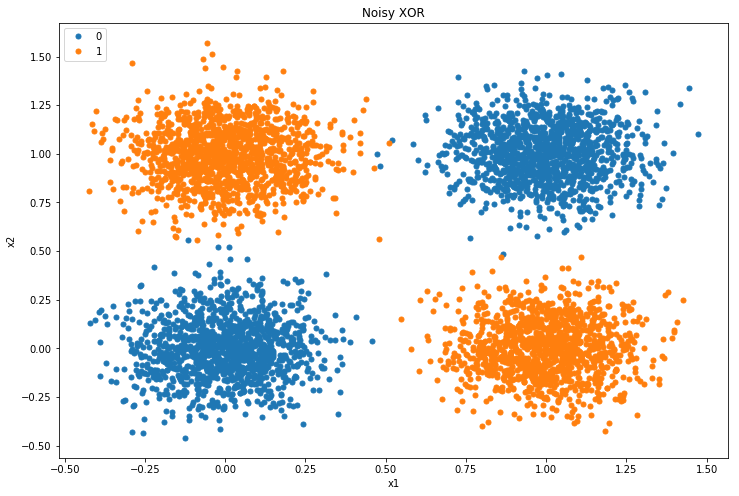

In [5]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

# Implement neural network

In [10]:
# helper functions
def sigmoid(x):
    return 1/(np.exp(-x)+1)

def ReLU(x):
    return max(0, x)

def softplus(x):
    if x > 100:
        return x
    return np.log(1+np.exp(x))

In [26]:
class MLP:   
    def initialize(self, n_input, n_hidden, n_output, batch_size=10, eta=0.01):
        # hidden layer
        self.W1 = np.random.rand(n_hidden, n_input)
        self.b1 = np.random.rand(1, n_hidden)
        # output layer
        self.W2 = np.random.rand(1, n_hidden)
        self.b2 = np.random.rand(1, 1)
        self.batch_size = batch_size
        self.eta = eta
        self.n_hidden = n_hidden

    # forward
    # h: 3 * n
    # z: 1 * n
    # y: 1 * n
    # X: 2 * n
    def fpropagation_hidden(self, X):
        # use input X to compute r and h
        r = X.dot(self.W1.T) + np.tile(self.b1, (self.batch_size, 1))    
        h = np.maximum(r, np.zeros(r.shape))
        return h, r
           
    def fpropagation_output(self, h):
        # use h to compute output z
        z = h.dot(self.W2.T) + self.b2
        return z
    
    def fpropagation_loss(self, z, y):
        # use z and y to compute L
        L = np.zeros((self.batch_size, 1))
        for i in range(self.batch_size):
            L[i, 0] = softplus((1-2*y[i, 0])*z[i, 0])
        L = np.mean(L)
        return L 
    
    def forward(self, X, y):
        h, r = self.fpropagation_hidden(X)
        z = self.fpropagation_output(h)
        L = self.fpropagation_loss(z, y)
        # print(L)
        return h, r, z, L

    def bpropagation_hidden(self, dLdh, r, X):
        dhdr = np.zeros((r.shape[0], r.shape[1]))
        for i in range(r.shape[0]):
            for j in range(r.shape[1]):            
                if r[i, j] > 0:
                    dhdr[i, j] = 1
                else:
                    dhdr[i, j] = 0
        # elementwise multiplication for non-linear functions
        dLdr = np.multiply(dLdh, dhdr)
        dLdW1 = dLdr.T.dot(X)
        dLdb1 = np.mean(dLdr * 1, axis=0)
        return dLdW1, dLdb1
   
    def bpropagation_output(self, dLdz, h):
        dLdW2 = dLdz.T.dot(h)            
#         print(dLdw)
#         print(dLdw.shape)
        dLdb2 = np.mean(dLdz * 1)
#         print(dLdb)
#         print(dLdb.shape)        
        dLdh = dLdz.dot(self.W2) 
#         print(dLdh.shape)
        return dLdh, dLdW2, dLdb2
    
    def bpropagation_loss(self, y, z):
        dLdz = np.zeros((self.batch_size, 1))
        for i in range(self.batch_size):
            dLdz[i, 0] = sigmoid((1-2*y[i, 0])*z[i, 0])*(1-2*y[i, 0])
        return dLdz
    
    def backward(self, X, y, h, r, z):
        dLdz = self.bpropagation_loss(y, z)
        dLdh, dLdW2, dLdb2 = self.bpropagation_output(dLdz, h)
        dLdW1, dLdb1 = self.bpropagation_hidden(dLdh, r, X)
        # update
        self.W1 -= self.eta*dLdW1
        self.W2 -= self.eta*dLdW2
        self.b1 -= self.eta*dLdb1
        self.b2 -= self.eta*dLdb2
        
    def predict(self, x):  
        z = np.maximum((x.dot(self.W1.T)+self.b1), np.zeros((1, self.n_hidden)))\
        .dot(self.W2.T) + self.b2
        P = sigmoid(float(z))
        if P>0.5:
            return 1
        else:
            return 0

In [8]:
X = X.A
y = y.A

# Train the network: batch size = 100, hidden units = 512, accuracy on training set = 0.9964

In [ ]:
mlp=None
mlp = MLP()
mlp.initialize(2, 512, 1, batch_size=100, eta=0.01)
All = np.concatenate((X, y), axis=1)
All = np.random.permutation(All)

L_new = 100
L = 90
i = 0
while(abs(L_new-L)>0.00001):
    if (i+1)*mlp.batch_size > All.shape[0]:
        All = np.random.permutation(All) 
        continue
    L = L_new
    X_train = All[i*mlp.batch_size:(i+1)*mlp.batch_size, 0:2]
    y_train = All[i*mlp.batch_size:(i+1)*mlp.batch_size, [2]]
    h, r, z, L_new = mlp.forward(X_train, y_train)
    print(L_new)
    mlp.backward(X_train, y_train, h, r, z)

In [42]:
error = 0
for i in range(X.shape[0]):
    label = mlp.predict(X[i, :])
    if label != y[i, 0]:
        #print("label: {}, y: {}".format(label, y[i, 0]))
        error+=1
print(error/X.shape[0])

0.0036


[ True False  True ...,  True  True  True]


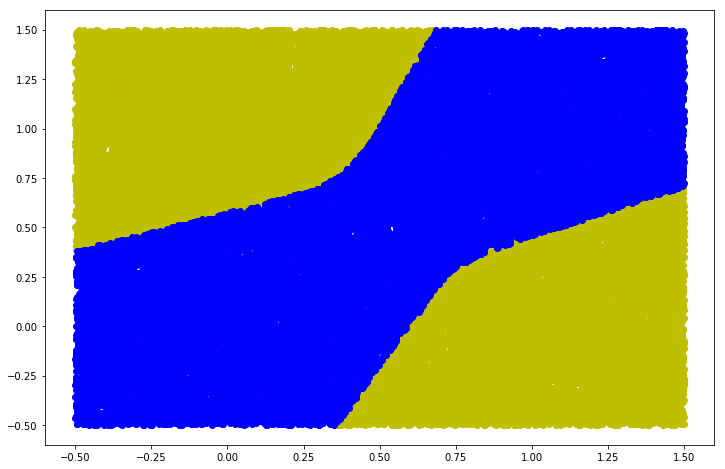

In [55]:
fig, ax = plt.subplots(figsize=(12,8))
data = np.random.uniform(-0.5, 1.5, (50000, 2))
predicted = np.zeros(50000)
for i in range(data.shape[0]):
    predicted[i] = mlp.predict(data[i, :])
ax.plot(data[predicted==1][:, 0], data[predicted==1][:, 1], "yo")
ax.plot(data[predicted==0][:, 0], data[predicted==0][:, 1], "bo")
plt.show()

# Train the network: batch size = 100, hidden units = 3, accuracy on training set = 0.9778

In [ ]:
mlp=None
mlp = MLP()
mlp.initialize(2, 3, 1, batch_size=100, eta=0.01)
All = np.concatenate((X, y), axis=1)
All = np.random.permutation(All)

L_new = 100
L = 90
i = 0
while(abs(L_new-L)>0.00001):
    if (i+1)*mlp.batch_size > All.shape[0]:
        All = np.random.permutation(All) 
        continue
    L = L_new
    X_train = All[i*mlp.batch_size:(i+1)*mlp.batch_size, 0:2]
    y_train = All[i*mlp.batch_size:(i+1)*mlp.batch_size, [2]]
    h, r, z, L_new = mlp.forward(X_train, y_train)
    print(L_new)
    mlp.backward(X_train, y_train, h, r, z)

In [60]:
error = 0
for i in range(X.shape[0]):
    label = mlp.predict(X[i, :])
    if label != y[i, 0]:
        #print("label: {}, y: {}".format(label, y[i, 0]))
        error+=1
print(error/X.shape[0])

0.0222


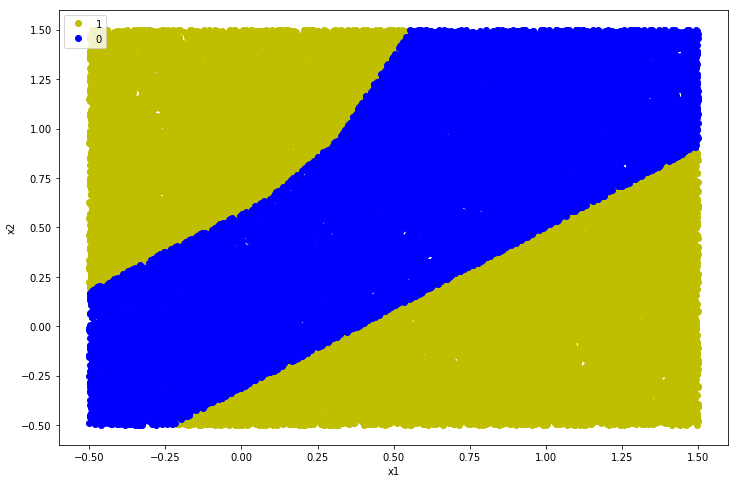

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
data = np.random.uniform(-0.5, 1.5, (50000, 2))
predicted = np.zeros(50000)
for i in range(data.shape[0]):
    predicted[i] = mlp.predict(data[i, :])
ax.plot(data[predicted==1][:, 0], data[predicted==1][:, 1], "yo", label="1")
ax.plot(data[predicted==0][:, 0], data[predicted==0][:, 1], "bo", label="0")
ax.legend()
ax.legend(loc=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()

# Train the network: batch size = 100, hidden units = 16, accuracy on training data = 0.9876

In [ ]:
mlp=None
mlp = MLP()
mlp.initialize(2, 16, 1, batch_size=100, eta=0.01)
All = np.concatenate((X, y), axis=1)
All = np.random.permutation(All)

L_new = 100
L = 90
i = 0
while(abs(L_new-L)>0.00001):
    if (i+1)*mlp.batch_size > All.shape[0]:
        All = np.random.permutation(All) 
        continue
    L = L_new
    X_train = All[i*mlp.batch_size:(i+1)*mlp.batch_size, 0:2]
    y_train = All[i*mlp.batch_size:(i+1)*mlp.batch_size, [2]]
    h, r, z, L_new = mlp.forward(X_train, y_train)
    print(L_new)
    mlp.backward(X_train, y_train, h, r, z)

In [67]:
error = 0
for i in range(X.shape[0]):
    label = mlp.predict(X[i, :])
    if label != y[i, 0]:
        #print("label: {}, y: {}".format(label, y[i, 0]))
        error+=1
print(error/X.shape[0])

0.0124


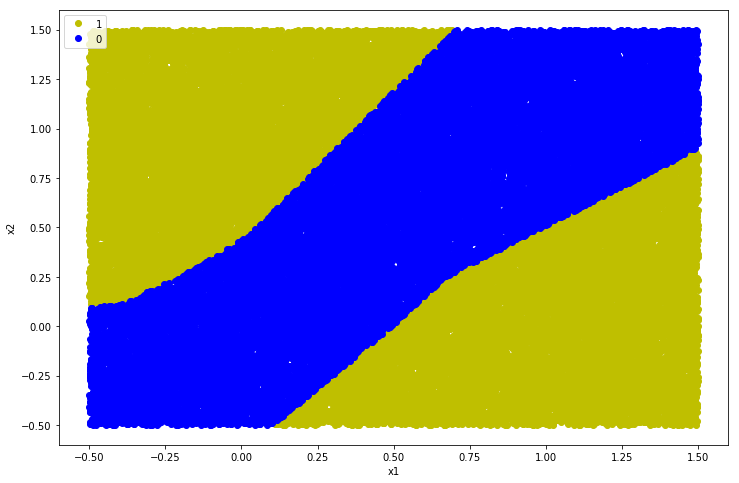

In [68]:
fig, ax = plt.subplots(figsize=(12,8))
data = np.random.uniform(-0.5, 1.5, (50000, 2))
predicted = np.zeros(50000)
for i in range(data.shape[0]):
    predicted[i] = mlp.predict(data[i, :])
ax.plot(data[predicted==1][:, 0], data[predicted==1][:, 1], "yo", label="1")
ax.plot(data[predicted==0][:, 0], data[predicted==0][:, 1], "bo", label="0")
ax.legend()
ax.legend(loc=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()

## Discussion: it is clear from the three graphs that when the number of hidden units increase, our neural network fits the training data better. Because our network have more complex structure to model more complicated functions if given more hidden units. But it might also take more time to train and  suffer from overfitting even though in our case it behaves just fine.

# Try a different loss function. I choose to use the squared error loss function. So $L = 1/2n \times \sum_i^n( \sigma(z_i) - y_i)^2$, where $\sigma$ is the sigmoid function. 


#  The only thing to change is the forward propagation of loss and to calculate $\frac{\partial L}{\partial z_i} = 1/n \times (\sigma(z_i) - y_i) \times \sigma(z_i)(1-\sigma(z_i))$, as I did in the following code.

In [101]:
class MLP:   
    def initialize(self, n_input, n_hidden, n_output, batch_size=10, eta=0.01):
        # hidden layer
        self.W1 = np.random.rand(n_hidden, n_input)
        self.b1 = np.random.rand(1, n_hidden)
        # output layer
        self.W2 = np.random.rand(1, n_hidden)
        self.b2 = np.random.rand(1, 1)
        self.batch_size = batch_size
        self.eta = eta
        self.n_hidden = n_hidden

    # forward
    # h: 3 * n
    # z: 1 * n
    # y: 1 * n
    # X: 2 * n
    def fpropagation_hidden(self, X):
        # use input X to compute r and h
        r = X.dot(self.W1.T) + np.tile(self.b1, (self.batch_size, 1))    
        h = np.maximum(r, np.zeros(r.shape))
        return h, r
           
    def fpropagation_output(self, h):
        # use h to compute output z
        z = h.dot(self.W2.T) + self.b2
        return z
    
    def fpropagation_loss(self, z, y):
        L = 0
        for i in range(self.batch_size):
            L += (sigmoid(z[i, 0]) - y[i, 0])**2
        L = 1/(2*self.batch_size) * L
        return L 
    
    def forward(self, X, y):
        h, r = self.fpropagation_hidden(X)
        z = self.fpropagation_output(h)
        L = self.fpropagation_loss(z, y)
        # print(L)
        return h, r, z, L

    def bpropagation_hidden(self, dLdh, r, X):
        dhdr = np.zeros((h.shape[0], h.shape[1]))
        for i in range(r.shape[0]):
            for j in range(r.shape[1]):            
                if r[i, j] > 0:
                    dhdr[i, j] = 1
                else:
                    dhdr[i, j] = 0
        # elementwise multiplication for non-linear functions
        dLdr = np.multiply(dLdh, dhdr)
        dLdW1 = dLdr.T.dot(X)
        dLdb1 = np.mean(dLdr * 1, axis=0)
        return dLdW1, dLdb1
   
    def bpropagation_output(self, dLdz, h):
        dLdW2 = dLdz.T.dot(h)            
#         print(dLdw)
#         print(dLdw.shape)
        dLdb2 = np.mean(dLdz * 1)
#         print(dLdb)
#         print(dLdb.shape)        
        dLdh = dLdz.dot(self.W2) 
#         print(dLdh.shape)
        return dLdh, dLdW2, dLdb2
    
    def bpropagation_loss(self, y, z):
        dLdz = np.zeros((self.batch_size, 1))
        for i in range(self.batch_size):
            dLdz[i, 0] = 1/self.batch_size * (sigmoid(z[i, :]) - y[i, :]) * \
            sigmoid(z[i, :]) * (1-sigmoid(z[i, :]))
        return dLdz
    
    def backward(self, X, y, h, r, z):
        dLdz = self.bpropagation_loss(y, z)
        dLdh, dLdW2, dLdb2 = self.bpropagation_output(dLdz, h)
        dLdW1, dLdb1 = self.bpropagation_hidden(dLdh, r, X)
        # update
        self.W1 -= self.eta*dLdW1
        self.W2 -= self.eta*dLdW2
        self.b1 -= self.eta*dLdb1
        self.b2 -= self.eta*dLdb2
        
    def predict(self, x):  
        z = np.maximum((x.dot(self.W1.T)+self.b1), np.zeros((1, self.n_hidden)))\
        .dot(self.W2.T) + self.b2
        P = sigmoid(float(z))
        if P>0.5:
            return 1
        else:
            return 0